# Homework 1

Erick Hernández Silva A01750170

Israel Sánchez Miranda A01378705

First install all necessary libraries and dependencies.

In [2]:
import numpy as np                # For complex mathematical operations
import pandas as pd               # For making dataframes
import matplotlib.pyplot as plt   # For plotting graphs

from tqdm import tqdm             # For progress line-bar showing

## Continuous hill climber method for single objective minimization problems.

We first define the function to compute the hill climber method, we defined a default step size of 0.01 and a maximum number of 1000 iterations. We also implemented path tracking within the function in order to be able to plot the path the method traversed before arriving to the best value it could find. 

As the algorithm suggests, we generate a random uniform perturbation within the radius of the step size to generate a new $x_{t+1}$ value. Then, we test if the value of the function is better than the current best one. Since we are aiming to minimize single objective problems we have check the condition `new_val < best_val`, if the contidion is met, then `new_val` is now `best_val`. We then clip the new $x_{t+1}$ value to avoid overflow and append its value to the path array. Finally, we return the final $x$ value, its evaluation in the $f$ function, the path and the number of function evaluations for further analysis.

In [3]:
# Hill Climber Method with path tracking and iteration counting
def hill_climber(f, x0, step_size=0.01, max_iter=1000):
    """
    Continuous hill climber algorithm for single minimization problems.
    
    @parameters:
    - f: {function}
        The objective function to be optimized.
    - x0: {array-like}
        The initial point for the optimization.
    - step_size: {float} optional
        The step size for generating random perturbations. Default is 0.01.
    - max_iter: {int} optional
        The maximum number of iterations. Default is 1000.
        
    @returns:
    - x: {array-like}
        The optimized point.
    - best_val: {float}
        The value of the objective function at the optimized point.
    - path: {array-like}
        The path of points explored during the optimization.
    - func_evals: {int}
        The number of function evaluations performed during the optimization.
    """

    x = np.array(x0)
    best_val = f(*x)
    
    path = [x.copy()]  # Store the initial point
    func_evals = 1  # Initial function evaluation
    
    for i in tqdm(range(max_iter), desc="Hill Climber Progress"):
        # Generate a random perturbation and evaluate it on f
        perturbation = np.random.uniform(-step_size, step_size, size=x.shape)
        new_x = x + perturbation
        new_val = f(*new_x)
        func_evals += 1
        
        # If the new point is better, move to it
        if new_val < best_val:
            x = new_x
            best_val = new_val
        
        # Clip the values to avoid overflow
        x = np.clip(x, -1e2, 1e2)
        
        # Store the current point in the path
        path.append(x.copy())
        
        # Print the progress every 100 iterations
        if i % 100 == 0 or i == max_iter - 1:
            print(f"Iteration {i}: Best Value = {best_val}, Current Point = {x}")
    
    return x, best_val, np.array(path), func_evals

## Gradient descent with Wolfe contidions.

We now implement a gradient descent method using the Wolfe conditions for step size control. The function we defined takes the function, its gradient and a starting point. We also define other parameters like the step size `t`, the Wolfe constants `c1` and `c2` and the maximum number of iterations, which is defaulted to 20. This function also has path tracking and function and gradient evaluations for further analysis. 

We define a function within `gradient_descent_wolfe` named `wolfe_condition` which computes wether the conditions are met. Remembering the Wolfe conditions defined by:

\begin{equation}
  f(x+tp)<=f(x)+c_1t\nabla f(x)^Tp
  \tag{1}
\end{equation}

\begin{equation}
  \nabla f(x+tp)^Tp>=c_2\nabla f(x)^Tp
  \tag{2}
\end{equation}

We firstly initialize the step_size and evaluate the initial vector $x_0$ over the gradient $\nabla f(x)$ to get the direction. We then enter a loop where we reduce or increase the step size using the Wolfe conditions defined by (3) and (4) until the conditions (1) and (2) are met. 

\begin{equation}
  f(x+tp)>f(x)+c_1t\nabla f(x)^Tp
  \tag{3}
\end{equation}

\begin{equation}
  \nabla f(x+tp)^Tp<c_2\nabla f(x)^Tp
  \tag{4}
\end{equation}

After defining a step size we compute the new $x_{t+1}$ value using $x_{t+1}=x_{t}+t*-\nabla f(x_{t})$. The new value of $x$ is clipped to avoid overflow and we append it to the path array, we finally check the stop criterion `np.linalg.norm(grad) < 1e-8` or stop if the maximum number of iterations is met. We return the final $x$ vector, its evaluation over $f$, the path array, the number of function and gradient evaluations.

In [4]:
# Gradient Descent with Wolfe Conditions, path tracking and iteration counting
def gradient_descent_wolfe(f, grad_f, x0, t=1.0, c1=1e-4, c2=0.9, max_iter=20):
    """
    Gradient descent algorithm with Wolfe conditions
    
    @parameters:
    - f: {function}
        The objective function to be optimized.
    - grad_f: {array-like}
        The gradient of the function to optimize.
    - x0: {array-like}
        The initial point for the optimization.
    - t: {float} optional
        The step size for the optimization process. Default is 1.0.
    - c1: {float} optional
        The first Wolfe constant. Default is 1e-4.
    - c2: {float} optional
        The second Wolfe constant. Default is 0.9
    - max_iter: {int} optional
        The maximum number of iterations. Default is 20.
        
    @returns:
    - x: {array-like}
        The optimized point.
    - f(*x): {float}
        The value of the objective function at the optimized point.
    - np.array(path): {array-like}
        The path of points explored during the optimization.
    - func_evals: {int}
        The number of function evaluations performed during the optimization.
    - grad_evals: {int}
        The number of gradient evaluations performed durint the optimization.
    """

    x = np.array(x0)
    max_wolfe_iter = max_iter
    initial_t = t
    
    path = [x.copy()]  # Store the initial point
    func_evals = 1  # Initial function evaluation
    grad_evals = 1  # Initial gradient evaluation
    
    def wolfe_conditions(t, grad, direction):
        return (f(*(x + t * direction)) <= f(*x) + c1 * t * np.dot(grad, direction)) and \
               (np.dot(grad_f(*(x + t * direction)), direction) >= c2 * np.dot(grad, direction))
    
    for i in tqdm(range(max_iter), desc="Gradient Descent Progress"):
        grad = grad_f(*x)
        grad_evals += 1
        direction = -grad
        wolfe_iter = 0
        t = initial_t
        
        # Step size control using Wolfe conditions
        while not wolfe_conditions(t, grad, direction) and wolfe_iter < max_wolfe_iter:
            if f(*(x + t * direction)) > f(*x) + c1 * t * np.dot(grad, direction):
                t *= 0.5
            elif np.dot(grad_f(*(x + t * direction)), direction) < c2 * np.dot(grad, direction):
                t *= 2.0
            else:
                break
            wolfe_iter += 1
            func_evals += 1
        
        x = x + t * direction
        func_evals += 1
        
        # Clip the values to avoid overflow
        x = np.clip(x, -1e2, 1e2)
        
        # Store the current point in the path
        path.append(x.copy())
        
        # Print the progress
        if i % 10 == 0 or i == max_iter - 1:
            print(f"Iteration {i}: Current Value = {f(*x)}, Current Point = {x}")
        
        # Check for stopping criterion
        if np.linalg.norm(grad) < 1e-8:
            break
    
    return x, f(*x), np.array(path), func_evals, grad_evals

## Newton method for optimization.

We defined a method to implement the Newton method for optimization problems. This function takes as parameters the function to optimize $f$, its gradient $\nabla f$, its Hessian matrix $\nabla^2 f$ and the inital vector $x_0$. We also define optional parameters like the minimum number of iterations, defaulted to 20, and the maximum number of iterations, which is 100. 

We first evaluate the vector over the gradient and the Hessian to get the direction and step size respectively. The new value of $x$ is clipped to avoid overflow and then we append it to the path array. We return the final $x$ vector, the path array and the number of function, gradient and Hessian evaluations.

In [5]:
# Newton's Method with path tracking, iteration counting, and stopping criterion
def newton_method(f, grad_f, hess_f, x0, min_iter=20, max_iter=100):
    """
    Newton's method for finding the minimum of a function.

    @parameters:
    - f: {function}
        The objective function to minimize.
    - grad_f: {array-like} 
        The gradient of the objective function.
    - hess_f: {matrix} 
        The Hessian matrix of the objective function.
    - x0: {array-like} 
        The initial point for the optimization.
    - min_iter: {int}
        The minimum number of iterations to perform. Default is 20.
    - max_iter: {int}
        The maximum number of iterations to perform. Default is 100.

    @returns:
    - x: {array-like} 
        The optimized point.
    - f(*x): {float}
        The value of the objective function at the optimized point.
    - np.array(path): {array-like}
        The path of points visited during the optimization.
    - func_evals: {int} 
        The number of function evaluations performed.
    - grad_evals: {int} 
        The number of gradient evaluations performed.
    - hess_evals: {int} 
        The number of Hessian evaluations performed.
    """

    x = np.array(x0)
    
    path = [x.copy()]  # Store the initial point
    func_evals = 1  # Initial function evaluation
    grad_evals = 1  # Initial gradient evaluation
    hess_evals = 1  # Initial Hessian evaluation
    
    for i in tqdm(range(max_iter), desc="Newton Method Progress"):
        grad = grad_f(*x)
        hess = hess_f(*x)
        grad_evals += 1
        hess_evals += 1
        
        # Solve for the search direction
        direction = np.linalg.solve(hess, -grad)
        
        x = x + direction
        func_evals += 1
        
        # Clip the values to avoid overflow
        x = np.clip(x, -1e2, 1e2)
        
        # Store the current point in the path
        path.append(x.copy())
        
        # Print the progress
        
        print(f"Iteration {i}: Current Value = {f(*x)}, Current Point = {x}")
        
        # Check for stopping criterion after minimum iterations
        if i >= min_iter and np.linalg.norm(grad) < 1e-4:
            print('STOPPING CRITERION REACHED')
            break
    
    return x, f(*x), np.array(path), func_evals, grad_evals, hess_evals


## Testing the methods.

### Initial considerations.

To test the methods we first define a method to compute the error of each function which consists of: 

\begin{equation}
  ||x'-x||
  \tag{5}
\end{equation}

Where:
* $x'$ is the computed minimum vector and
* $x$ is the real minimum vector.

In [6]:
# Function to compute the two-norm error
def compute_error(obtained_value, true_value):
    """
    Function to compute the two-norm error

    @parameters:
    - obtained_value: {numpy.ndarray} 
        The obtained value.
    - true_value: {numpy.ndarray}
        The true value.

    @returns:
    - The error {float} between the obtained value and the true value.
    """
    
    return np.linalg.norm(obtained_value - true_value)

We now define the functions to minimize, the first function is:

\begin{equation}
  f(x_1,x_2)=-2x_1^2+3x_1x_2-1.5x_2^2-1.3
  \tag{6}
\end{equation}

Where $-6\leq x_1,x_2\leq 6$ and we use $[-4,4]^T\in\R^2$ as a starting point. Since this is a maximization problem we multiply (6) by -1 to change it into a minimization one.

In [7]:
def func1(x1, x2):
  return 2*x1**2 - 3*x1*x2 + 1.5*x2**2 + 1.3

The second function is:

\begin{equation}
  f(x_1,x_2)=(4-2.1x_1^2+\frac{x_1^4}3)x_1^2+x_1x_2+(-4+4x_2^2)x_2^2
  \tag{7}
\end{equation}

Where $-3\leq x_1\leq 3$, $-2\leq x_2\leq 2$ and we use $[0.5,1]^T\in\R^2$ as a starting point.

In [8]:
def func2(x1, x2):
    return np.clip((4 - 2.1*x1**2 + x1**4 / 3) * x1**2 + x1*x2 + (-4 + 4*x2**2) * x2**2, -1e10, 1e10)

The final function is the Rastrigin function in 2D: 

\begin{equation}
  f(x_1,x_2)=A*2+(x_1^2-A*\cos(2\pi x_1))+(x_2^2-A*\cos(2\pi x_2))
  \tag{8}
\end{equation}

Where $A$ is a constant, typically 10, and we use $[-2.2]^T\in\R^2$ as a starting point.

In [9]:
def rastrigin_2d(x1, x2, A=10):
    return A * 2 + (x1**2 - A * np.cos(2 * np.pi * x1)) + (x2**2 - A * np.cos(2 * np.pi * x2))

We need the gradients of each function for the gradient descent method, so we define them:

In [10]:
# Define the gradients
def grad_func1(x1, x2):
  df_dx1 = -4*x1 + 3*x2
  df_dx2 = 3*x1 - 3*x2
  return np.array([df_dx1, df_dx2])

def grad_func2(x1, x2):
  df_dx1 = (8*x1 - 4.2*x1**3 + 4*x1**3) + x2
  df_dx2 = x1 + (8*x2**3 - 8*x2)
  return np.array([df_dx1, df_dx2])

def grad_rastrigin_2d(x1, x2, A=10):
  grad_x1 = 2*x1 + 2 * np.pi * A * np.sin(2 * np.pi * x1)
  grad_x2 = 2*x2 + 2 * np.pi * A * np.sin(2 * np.pi * x2)
  return np.array([grad_x1, grad_x2])

We also need to define the Hessian matrixes for the Newton method:

In [11]:
# Define the Hessians
def hess_func1(x1, x2):
  d2f_dx1x1 = -4
  d2f_dx1x2 = 3
  d2f_dx2x1 = 3
  d2f_dx2x2 = -3
  return np.array([[d2f_dx1x1, d2f_dx1x2], [d2f_dx2x1, d2f_dx2x2]])

def hess_func2(x1, x2):
  d2f_dx1x1 = 8 - 12.6*x1**2 + 12*x1**2
  d2f_dx1x2 = 1
  d2f_dx2x1 = 1
  d2f_dx2x2 = 24*x2**2 - 8
  return np.array([[d2f_dx1x1, d2f_dx1x2], [d2f_dx2x1, d2f_dx2x2]])

def hess_rastrigin_2d(x1, x2, A=10):
  hess_x1x1 = 2 + 4 * np.pi**2 * A * np.cos(2 * np.pi * x1)
  hess_x2x2 = 2 + 4 * np.pi**2 * A * np.cos(2 * np.pi * x2)
  hess_x1x2 = 0
  hess_x2x1 = 0
  return np.array([[hess_x1x1, hess_x1x2], [hess_x2x1, hess_x2x2]])

We also define the starting points and the true minimum values, we assume all of them are in the point $[0,0]$.

In [12]:
# Starting points
x0_func1 = [-4, 4]
x0_func2 = [0.5, 1]
x0_rastrigin = [-2, 2]

# True optimal values (if known)
true_min_func1 = np.array([0, 0])
true_min_func2 = np.array([0, 0])  # Assumed, depending on the function specifics
true_min_rastrigin = np.array([0, 0])

We also initialize a dictionary where we will store the results:

In [13]:
# Initialize results dictionary
results = {
  'Function': [],
  'Method': [],
  'Iterations': [],
  'Function Evals': [],
  'Gradient Evals': [],
  'Hessian Evals': [],
  'Final Error (2-norm)': []
}

### Minimizing the functions.

We test the hill climber method with the three functions:

In [14]:
# Test Hill Climber
print("Testing Hill Climber Method:")
hc_result_func1, _, hc_path_func1, hc_func_evals_func1 = hill_climber(func1, x0_func1)
hc_result_func2, _, hc_path_func2, hc_func_evals_func2 = hill_climber(func2, x0_func2)
hc_result_rastrigin, _, hc_path_rastrigin, hc_func_evals_rastrigin = hill_climber(rastrigin_2d, x0_rastrigin)

Testing Hill Climber Method:


Hill Climber Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Hill Climber Progress: 100%|██████████| 1000/1000 [00:00<00:00, 15364.09it/s]


Iteration 0: Best Value = 105.3, Current Point = [-4.  4.]
Iteration 100: Best Value = 94.87465671760891, Current Point = [-3.75951528  3.83467896]
Iteration 200: Best Value = 86.02728711217478, Current Point = [-3.57126838  3.65600903]
Iteration 300: Best Value = 77.43616679587922, Current Point = [-3.39662477  3.4525911 ]
Iteration 400: Best Value = 71.67742640065548, Current Point = [-3.26964452  3.31478858]
Iteration 500: Best Value = 65.69540026566291, Current Point = [-3.07173313  3.23580881]
Iteration 600: Best Value = 56.76350833168178, Current Point = [-2.78935938  3.0742712 ]
Iteration 700: Best Value = 50.158304565287594, Current Point = [-2.6512585   2.84684534]
Iteration 800: Best Value = 44.16420686524064, Current Point = [-2.47086378  2.68093998]
Iteration 900: Best Value = 38.762576293240485, Current Point = [-2.29649386  2.52191765]
Iteration 999: Best Value = 33.50433011922715, Current Point = [-2.08431505  2.39021625]


Hill Climber Progress: 100%|██████████| 1000/1000 [00:00<00:00, 13462.40it/s]


Iteration 0: Best Value = 1.3681191090673048, Current Point = [0.4951915  1.00157477]
Iteration 100: Best Value = 0.19067232811881807, Current Point = [0.41495622 0.85336798]
Iteration 200: Best Value = -0.6459613898891838, Current Point = [0.17928076 0.8028968 ]
Iteration 300: Best Value = -1.0239984207857968, Current Point = [-0.04608348  0.70539543]
Iteration 400: Best Value = -1.0315920464619368, Current Point = [-0.08827812  0.71437286]
Iteration 500: Best Value = -1.0316269613019982, Current Point = [-0.08996421  0.71308226]
Iteration 600: Best Value = -1.0316269613019982, Current Point = [-0.08996421  0.71308226]
Iteration 700: Best Value = -1.0316269613019982, Current Point = [-0.08996421  0.71308226]
Iteration 800: Best Value = -1.0316282277546562, Current Point = [-0.08976946  0.71281032]
Iteration 900: Best Value = -1.0316282277546562, Current Point = [-0.08976946  0.71281032]
Iteration 999: Best Value = -1.0316282277546562, Current Point = [-0.08976946  0.71281032]


Hill Climber Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0: Best Value = 8.0, Current Point = [-2.  2.]
Iteration 100: Best Value = 7.96019868120715, Current Point = [-1.99107164  1.98874415]
Iteration 200: Best Value = 7.959795731179595, Current Point = [-1.98911149  1.99009218]
Iteration 300: Best Value = 7.959795731179595, Current Point = [-1.98911149  1.99009218]
Iteration 400: Best Value = 7.959689757513666, Current Point = [-1.98978179  1.98956401]
Iteration 500: Best Value = 7.95968596797711, Current Point = [-1.98960007  1.98976498]
Iteration 600: Best Value = 7.95968596797711, Current Point = [-1.98960007  1.98976498]
Iteration 700: Best Value = 7.95968596797711, Current Point = [-1.98960007  1.98976498]


Hill Climber Progress: 100%|██████████| 1000/1000 [00:00<00:00, 21741.95it/s]

Iteration 800: Best Value = 7.95968596797711, Current Point = [-1.98960007  1.98976498]
Iteration 900: Best Value = 7.95968596797711, Current Point = [-1.98960007  1.98976498]
Iteration 999: Best Value = 7.95968596797711, Current Point = [-1.98960007  1.98976498]


Then with the gradient descent method:

In [15]:
# Test Gradient Descent with Wolfe Conditions
print("Testing Gradient Descent with Wolfe Conditions:")
gd_result_func1, _, gd_path_func1, gd_func_evals_func1, gd_grad_evals_func1 = gradient_descent_wolfe(func1, grad_func1, x0_func1)
gd_result_func2, _, gd_path_func2, gd_func_evals_func2, gd_grad_evals_func2 = gradient_descent_wolfe(func2, grad_func2, x0_func2)
gd_result_rastrigin, _, gd_path_rastrigin, gd_func_evals_rastrigin, gd_grad_evals_rastrigin = gradient_descent_wolfe(rastrigin_2d, grad_rastrigin_2d, x0_rastrigin)

Testing Gradient Descent with Wolfe Conditions:


Gradient Descent Progress: 100%|██████████| 20/20 [00:00<00:00, 1333.62it/s]


Iteration 0: Current Value = 105.30129700111574, Current Point = [-4.0000267   4.00002289]
Iteration 10: Current Value = 105.31426790230724, Current Point = [-4.00029374  4.00025178]
Iteration 19: Current Value = 105.32594309709297, Current Point = [-4.00053409  4.00045779]


Gradient Descent Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration 0: Current Value = 1.1035124149589484, Current Point = [-1.9875  0.75  ]

Gradient Descent Progress: 100%|██████████| 20/20 [00:00<00:00, 300.60it/s]



Iteration 10: Current Value = 0.060061190513864826, Current Point = [-1.56303775  0.89416635]
Iteration 19: Current Value = 0.06029955518089081, Current Point = [-1.56294466  0.89419207]


Gradient Descent Progress:   5%|▌         | 1/20 [00:00<00:00, 333.23it/s]

Iteration 0: Current Value = 0.0, Current Point = [-1.53210777e-14  1.53210777e-14]


And finally the Newton method:

In [16]:
# Test Newton's Method
print("Testing Newton's Method:")
newton_result_func1, _, newton_path_func1, newton_func_evals_func1, newton_grad_evals_func1, newton_hess_evals_func1 = newton_method(func1, grad_func1, hess_func1, x0_func1)
newton_result_func2, _, newton_path_func2, newton_func_evals_func2, newton_grad_evals_func2, newton_hess_evals_func2 = newton_method(func2, grad_func2, hess_func2, x0_func2)
newton_result_rastrigin, _, newton_path_rastrigin, newton_func_evals_rastrigin, newton_grad_evals_rastrigin, newton_hess_evals_rastrigin = newton_method(rastrigin_2d, grad_rastrigin_2d, hess_rastrigin_2d, x0_rastrigin)

Testing Newton's Method:


Newton Method Progress:  20%|██        | 20/100 [00:00<00:00, 2853.85it/s]


Iteration 0: Current Value = 1.3, Current Point = [0. 0.]
Iteration 1: Current Value = 1.3, Current Point = [0. 0.]
Iteration 2: Current Value = 1.3, Current Point = [0. 0.]
Iteration 3: Current Value = 1.3, Current Point = [0. 0.]
Iteration 4: Current Value = 1.3, Current Point = [0. 0.]
Iteration 5: Current Value = 1.3, Current Point = [0. 0.]
Iteration 6: Current Value = 1.3, Current Point = [0. 0.]
Iteration 7: Current Value = 1.3, Current Point = [0. 0.]
Iteration 8: Current Value = 1.3, Current Point = [0. 0.]
Iteration 9: Current Value = 1.3, Current Point = [0. 0.]
Iteration 10: Current Value = 1.3, Current Point = [0. 0.]
Iteration 11: Current Value = 1.3, Current Point = [0. 0.]
Iteration 12: Current Value = 1.3, Current Point = [0. 0.]
Iteration 13: Current Value = 1.3, Current Point = [0. 0.]
Iteration 14: Current Value = 1.3, Current Point = [0. 0.]
Iteration 15: Current Value = 1.3, Current Point = [0. 0.]
Iteration 16: Current Value = 1.3, Current Point = [0. 0.]
Iterati

Newton Method Progress:  20%|██        | 20/100 [00:00<00:00, 2500.63it/s]


Iteration 0: Current Value = 0.0049039740624900185, Current Point = [-0.13483146  1.00842697]
Iteration 1: Current Value = -0.0004984952218581584, Current Point = [-0.1260225   1.00778586]
Iteration 2: Current Value = -0.0005031307994367712, Current Point = [-0.1260232  1.0077853]
Iteration 3: Current Value = -0.000503130803321053, Current Point = [-0.1260232  1.0077853]
Iteration 4: Current Value = -0.000503130803321053, Current Point = [-0.1260232  1.0077853]
Iteration 5: Current Value = -0.000503130803321053, Current Point = [-0.1260232  1.0077853]
Iteration 6: Current Value = -0.000503130803321053, Current Point = [-0.1260232  1.0077853]
Iteration 7: Current Value = -0.000503130803321053, Current Point = [-0.1260232  1.0077853]
Iteration 8: Current Value = -0.000503130803321053, Current Point = [-0.1260232  1.0077853]
Iteration 9: Current Value = -0.000503130803321053, Current Point = [-0.1260232  1.0077853]
Iteration 10: Current Value = -0.000503130803321053, Current Point = [-0.1

Newton Method Progress:  20%|██        | 20/100 [00:00<00:00, 2860.27it/s]

Iteration 0: Current Value = 7.959662398985785, Current Point = [-1.98991895  1.98991895]
Iteration 1: Current Value = 7.959662381108174, Current Point = [-1.98991223  1.98991223]
Iteration 2: Current Value = 7.959662381108174, Current Point = [-1.98991223  1.98991223]
Iteration 3: Current Value = 7.959662381108174, Current Point = [-1.98991223  1.98991223]
Iteration 4: Current Value = 7.959662381108174, Current Point = [-1.98991223  1.98991223]
Iteration 5: Current Value = 7.959662381108174, Current Point = [-1.98991223  1.98991223]
Iteration 6: Current Value = 7.959662381108174, Current Point = [-1.98991223  1.98991223]
Iteration 7: Current Value = 7.959662381108174, Current Point = [-1.98991223  1.98991223]
Iteration 8: Current Value = 7.959662381108174, Current Point = [-1.98991223  1.98991223]
Iteration 9: Current Value = 7.959662381108174, Current Point = [-1.98991223  1.98991223]
Iteration 10: Current Value = 7.959662381108174, Current Point = [-1.98991223  1.98991223]
Iteration

We stored the results in the dictionary, then converted it into a dataframe and finally stored the information in a `.csv` file.

In [17]:
# Store results in the results dictionary
methods = ['Hill Climber', 'Newton', 'Gradient Descent Wolfe']
functions = ['Function 1', 'Function 2', 'Rastrigin']
results_list = [
  (hc_result_func1, hc_path_func1, hc_func_evals_func1, 0, 0, true_min_func1, 'Function 1', 'Hill Climber'),
  (hc_result_func2, hc_path_func2, hc_func_evals_func2, 0, 0, true_min_func2, 'Function 2', 'Hill Climber'),
  (hc_result_rastrigin, hc_path_rastrigin, hc_func_evals_rastrigin, 0, 0, true_min_rastrigin, 'Rastrigin', 'Hill Climber'),
  (newton_result_func1, newton_path_func1, newton_func_evals_func1, newton_grad_evals_func1, newton_hess_evals_func1, true_min_func1, 'Function 1', 'Newton'),
  (newton_result_func2, newton_path_func2, newton_func_evals_func2, newton_grad_evals_func2, newton_hess_evals_func2, true_min_func2, 'Function 2', 'Newton'),
  (newton_result_rastrigin, newton_path_rastrigin, newton_func_evals_rastrigin, newton_grad_evals_rastrigin, newton_hess_evals_rastrigin, true_min_rastrigin, 'Rastrigin', 'Newton'),
  (gd_result_func1, gd_path_func1, gd_func_evals_func1, gd_grad_evals_func1, 0, true_min_func1, 'Function 1', 'Gradient Descent Wolfe'),
  (gd_result_func2, gd_path_func2, gd_func_evals_func2, gd_grad_evals_func2, 0, true_min_func2, 'Function 2', 'Gradient Descent Wolfe'),
  (gd_result_rastrigin, gd_path_rastrigin, gd_func_evals_rastrigin, gd_grad_evals_rastrigin, 0, true_min_rastrigin, 'Rastrigin', 'Gradient Descent Wolfe')
]

for result, path, func_evals, grad_evals, hess_evals, true_min, func_name, method_name in results_list:
  results['Function'].append(func_name)
  results['Method'].append(method_name)
  results['Iterations'].append(len(path))
  results['Function Evals'].append(func_evals)
  results['Gradient Evals'].append(grad_evals)
  results['Hessian Evals'].append(hess_evals)
  results['Final Error (2-norm)'].append(compute_error(result, true_min))

# Convert results dictionary to a DataFrame for easy comparison
df_results = pd.DataFrame(results)
print(df_results)

# You can export the results to a CSV file if needed
df_results.to_csv('optimization_results.csv', index=False)

     Function                  Method  Iterations  Function Evals  \
0  Function 1            Hill Climber        1001            1001   
1  Function 2            Hill Climber        1001            1001   
2   Rastrigin            Hill Climber        1001            1001   
3  Function 1                  Newton          22              22   
4  Function 2                  Newton          22              22   
5   Rastrigin                  Newton          22              22   
6  Function 1  Gradient Descent Wolfe          21             421   
7  Function 2  Gradient Descent Wolfe          21             387   
8   Rastrigin  Gradient Descent Wolfe           3              24   

   Gradient Evals  Hessian Evals  Final Error (2-norm)  
0               0              0          3.171357e+00  
1               0              0          7.184407e-01  
2               0              0          2.813836e+00  
3              22             22          0.000000e+00  
4              22       

## Results.

We first made a contour plot for every function and displayed the path each method traversed to arrieve to the minimum.

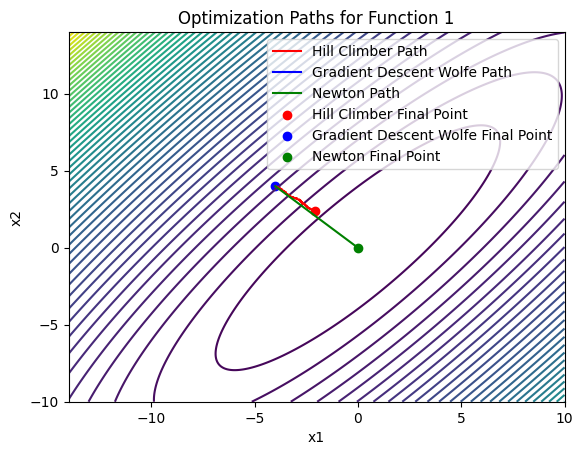

In [18]:
# Visualization for Function 1
x1_vals = np.linspace(min(hc_path_func1[:, 0].min(), gd_path_func1[:, 0].min(), newton_path_func1[:, 0].min()) - 10, 10, 400)
x2_vals = np.linspace(-10, max(hc_path_func1[:, 1].max(), gd_path_func1[:, 1].max(), newton_path_func1[:, 1].max()) + 10, 400)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z1 = func1(X1, X2)

plt.contour(X1, X2, Z1, levels=50)
plt.plot(hc_path_func1[:, 0], hc_path_func1[:, 1], 'r-', label='Hill Climber Path')
plt.plot(gd_path_func1[:, 0], gd_path_func1[:, 1], 'b-', label='Gradient Descent Wolfe Path')
plt.plot(newton_path_func1[:, 0], newton_path_func1[:, 1], 'g-', label='Newton Path')
plt.scatter(hc_result_func1[0], hc_result_func1[1], color='red', label='Hill Climber Final Point')
plt.scatter(gd_result_func1[0], gd_result_func1[1], color='blue', label='Gradient Descent Wolfe Final Point')
plt.scatter(newton_result_func1[0], newton_result_func1[1], color='green', label='Newton Final Point')
plt.legend()
plt.title('Optimization Paths for Function 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

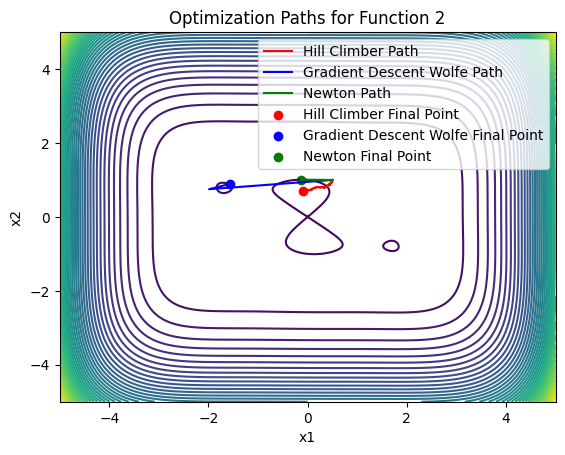

In [19]:
# Visualization for Function 2
x1_vals = np.linspace(-5, 5, 400)
x2_vals = np.linspace(-5, 5, 400)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z1 = func2(X1, X2)

plt.contour(X1, X2, Z1, levels=50)
plt.plot(hc_path_func2[:, 0], hc_path_func2[:, 1], 'r-', label='Hill Climber Path')
plt.plot(gd_path_func2[:, 0], gd_path_func2[:, 1], 'b-', label='Gradient Descent Wolfe Path')
plt.plot(newton_path_func2[:, 0], newton_path_func2[:, 1], 'g-', label='Newton Path')
plt.scatter(hc_result_func2[0], hc_result_func2[1], color='red', label='Hill Climber Final Point')
plt.scatter(gd_result_func2[0], gd_result_func2[1], color='blue', label='Gradient Descent Wolfe Final Point')
plt.scatter(newton_result_func2[0], newton_result_func2[1], color='green', label='Newton Final Point')
plt.legend()
plt.title('Optimization Paths for Function 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

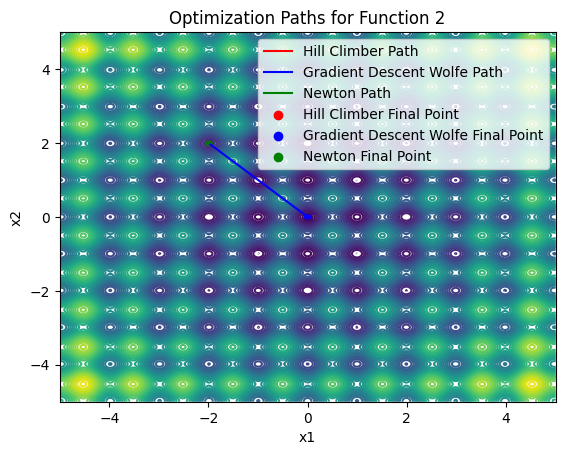

In [20]:
# Visualization for Rastrigin
x1_vals = np.linspace(-5, 5, 400)
x2_vals = np.linspace(-5, 5, 400)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z1 = rastrigin_2d(X1, X2)

plt.contour(X1, X2, Z1, levels=50)
plt.plot(hc_path_rastrigin[:, 0], hc_path_rastrigin[:, 1], 'r-', label='Hill Climber Path')
plt.plot(gd_path_rastrigin[:, 0], gd_path_rastrigin[:, 1], 'b-', label='Gradient Descent Wolfe Path')
plt.plot(newton_path_rastrigin[:, 0], newton_path_rastrigin[:, 1], 'g-', label='Newton Path')
plt.scatter(hc_result_rastrigin[0], hc_result_rastrigin[1], color='red', label='Hill Climber Final Point')
plt.scatter(gd_result_rastrigin[0], gd_result_rastrigin[1], color='blue', label='Gradient Descent Wolfe Final Point')
plt.scatter(newton_result_rastrigin[0], newton_result_rastrigin[1], color='green', label='Newton Final Point')
plt.legend()
plt.title('Optimization Paths for Function 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Discussion and conclusions.

In Table 1, we can see the number of iterations needed to find a nearly optimalsolution per method.
#### Table 1: Performance Comparison of Optimization Methods.

| **Function**   | **Method**                  | **Iterations** | **Function Evals** | **Gradient Evals** | **Hessian Evals** | **Final Error (2-norm)** |
|----------------|-----------------------------|----------------|--------------------|--------------------|-------------------|--------------------------|
| Function 1     | Hill Climber                | 1001           | 1001               | 0                  | 0                 | 3.171                    |
| Function 2     | Hill Climber                | 1001           | 1001               | 0                  | 0                 | 0.718                    |
| Rastrigin      | Hill Climber                | 1001           | 1001               | 0                  | 0                 | 2.814                    |
| Function 1     | Newton                      | 22             | 22                 | 22                 | 22                | 0.0                      |
| Function 2     | Newton                      | 22             | 22                 | 22                 | 22                | 1.016                    |
| Rastrigin      | Newton                      | 22             | 22                 | 22                 | 22                | 2.814                    |
| Function 1     | Gradient Descent Wolfe      | 21             | 421                | 21                 | 0                 | 5.658                    |
| Function 2     | Gradient Descent Wolfe      | 21             | 387                | 21                 | 0                 | 1.800                    |
| Rastrigin      | Gradient Descent Wolfe      | 3              | 24                 | 3                  | 0                 | 2.165e-14                |

### Analysis of Methods.

1. **Function 1**: 
   - The Newton method achieved the exact optimal solution (`Final Error = 0.0`) in just 22 iterations, indicating it is highly effective for this function.
   - The Hill Climber method had a large final error and required significantly more function evaluations and iterations, suggesting it's not suitable for this problem.
   - Gradient Descent Wolfe also performed poorly with a very high error eventhough it had the less iterations executed.

2. **Function 2**: 
   - Newton's method again performed better than the others, with a low final error, though it wasn't as close to zero as in Function 1.
   - The Hill Climber had a lower error compared to Newton's method but still wasn't optimal in terms of iterations.
   - Gradient Descent Wolfe also struggled, having a higher final error.

3. **Rastrigin Function**:
   - The Rastrigin function is known for its many local minima, making it challenging for derivative-based methods.
   - The Hill Climber and Newton methods both resulted in suboptimal errors, but Gradient Descent Wolfe managed an almost negligible error, suggesting it converged close to the global minimum.

Given the results, for the first function we would select the **Newton method** due to its rapid convergence and exact solution. This method is also preferable for the second function, though the final error was slightly higher; it performed better overall. For 2D Rastrigin, **Gradient Descent Wolfe** method is the best choice, as it achieved an almost perfect result with minimal error.

Eventhough gradient-based and mathematically defined methods perform well and have acceptable results, evolutionary algorithms could potentially be useful for optimizing functions. Evolutionary algorithms are generally more robust in exploring such landscapes since they do not rely on gradient information and can escape local minima more effectively, which is a main issue for the 2D Rastrigin function. For the other functions (like Function 1 and Function 2), which seem to be smoother or more convex, derivative-based methods (especially Newton's method) are more appropriate due to their efficiency and precision.

### Conclusions

The performance comparison across the different optimization methods reveals that the **Newton method** is the most efficient and accurate for smoother, more convex functions like Function 1 and Function 2, achieving rapid convergence with minimal iterations and exact or near-exact solutions. However, for more complex functions like the 2D Rastrigin, which are characterized by multiple local minima, **Gradient Descent Wolfe** stands out as the best performer, achieving an almost perfect solution with minimal error.

This analysis also suggests that while gradient-based and mathematically defined methods work well in smooth or convex landscapes, evolutionary algorithms could provide a significant advantage in optimizing functions with more complex landscapes, such as the Rastrigin function, due to their robustness and ability to escape local minima. Therefore, the choice of optimization method should be aligned with the characteristics of the function being optimized, with Newton's method being more appropriate for simpler functions and Gradient Descent Wolfe or evolutionary algorithms being better suited for more challenging, non-convex problems.